# Homework 7 Solutions

Due by March 3rd, 3:30 pm

## Instructions

* This submission has **one** component: 
   * iPython notebook with coded solution to problems 1, 2, and 3

Make sure your solutions are clear and legible!

### Other important information

* __Make sure to title the homework assignment as LASTNAME_FIRSTNAME_Homework7 before submitting.__

* All plots generated must have an xlabel, a ylabel, and a caption that interprets the plot. Time profiles also require a legend. 

* To create a caption, add a new cell below a plot by using the option "Insert > Insert Cell below", then change the cell into a markdown cell by using "Cell > Cell Type > Markdown".

* Axis limits must be sensible, meaning that you may need to set the axis limits via kwargs "xlim" and "ylim" in order to make your plot more interpretable. 



In [1]:
# Import stuff

from mass import (MassModel, MassMetabolite, MassReaction, Simulation, MassSolution, strip_time)
from mass.test import create_test_model
from mass.util.matrix import nullspace, left_nullspace, matrix_rank
from mass.visualization import (plot_time_profile, plot_phase_portrait, plot_tiled_phase_portraits)
import mass
from os import path
from cobra import DictList
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sym
pd.set_option('display.max_columns', None)

## Question 1: Hemoglobin module (30 Points)

> (i) Load the seperate glycolysis, pentose phosphate pathway, and AMP salvage network models. Combine the glycolysis, pentose phosphate pathway, and AMP salvage network with the hemoglobin module to create a single model representing the RBC core structure (will be referred to as the core RBC model).

> (ii) Calculate the steady state flux map and the PERCs for the core RBC model, setting the PERCs for oxygen-hemoglobin binding and the oxygen exchange manually. Then simulate to steady state and update the conditions of your model. Graphically show your model in its steady state.

> (iii) Simulate three different changes to the oyxgen partial pressure (47/70, 57/70 and 67/70), and plot the oxygen charge ratio ($r_{OHb}$),  the hemoglobin T/R ratio, and the 23DPG ratio for each simulation onto three graphs. Explain what this change means physiologically through analysis of the three graphs. Assume external oxygen concentration is a constant and does not oscillate. Note that 70mmHg is the baseline partial pressure of oxygen in our model.

__(i) Expected Output__: 
* The overview displayed when calling the core RBC model.
        
__(ii) Expected Output__: 
* A plot of the steady state concentrations.
* The steady state flux map of the model
* A table with your PERCs for your model
    
__(iii) Expected Output__:
* One plot containing the oxygen charge ratio solutions over time. 
* One plot containing the Hemoglobin T/R ratios over time. 
* One plot containing the 23DPG Ratios over time.
* Interpretation of the plots explaining what this means physiologically, using evidence from each of the graphs.

The MinSpan pathways needed to calculate the PERCs for **(ii)** are provided below.

In [2]:
minspan_paths = np.array([
    [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1, 0, 0, 0,-1, 1, 0, 0, 0, 0, 0,-2, 0, 0, 0, 0],
    [1,-2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 3, 3, 3, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 6, 6, 1, 0, 1, 0, 0, 0, 0, 0,13,-3, 3, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,-1, 0, 0, 0, 0, 0, 0, 0,-3, 0, 2, 2, 1, 0, 0,-1, 1, 0, 0, 0, 4, 0, 1, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,-1, 0, 0, 0, 0, 0, 0, 0,-3, 0, 2, 2, 1, 0, 0,-1, 0, 1, 0, 0, 4,-1, 1, 1, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,-1, 0, 0, 0, 0, 0, 0, 0,-3, 0, 2, 2, 1, 0, 0,-1, 0, 1, 0, 0, 4,-1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,-1, 0, 0, 0, 0, 0, 0, 0,-2, 0, 0, 0, 0, 0, 0,-1, 0, 0, 1, 0, 0,-1, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0]
])

### <font color=red> __Grading:__ </font>

 **(i)**
  -  +1 The overview obtained when calling the core RBC model.
  
**(ii)**
  - +1 The steady state graph of the core RBC model.
  - +2 Calculating and setting the PERCs for the hemoglobin model.
  - +2 Calculating the steady state map of the model.
**(iii)**
  - one plot containing the oxygen charge ratio solution over time. +5
  > - +1 for having graphs of all three concentrations
  > - +2 for correct graph
  > - +2 for correct labeling of axies, legends, etc
  - one plot containing the Hemoglobin T/R ratio over time. +5
  > - +1 for having graphs of all three concentrations
  > - +2 for correct graph
  > - +2 for correct labeling of axies, legends, etc
  - one plot containing the 23DPG ratio over time. +5
  > - +1 for having graphs of all three concentrations
  > - +2 for correct graph
  > - +2 for correct labeling of axies, legends, etc
  - Interpretation of the plots explaining what their results indicate about the physiological effects of changing the partial pressure of oxygen. +9 
  > - +1 for each graph referenced (+3 in total) 
  > - +3 for correct interpretation
  > - +3 for connection of results to physiological effects

<font color=red>**(i)**</font>

In [3]:
glycolysis = create_test_model("SB2_Glycolysis")
ppp = create_test_model("SB2_PentosePhosphatePathway")
ampsn = create_test_model("SB2_AMPSalvageNetwork")
hemoglobin = create_test_model("SB2_Hemoglobin")

In [4]:
core_hb = glycolysis.merge(ppp, inplace=False)
core_hb.merge(ampsn, inplace=True)
core_hb.remove_reactions([
    r for r in core_hb.boundary
    if r.id in [
        "SK_g6p_c", "DM_f6p_c", "DM_g3p_c", "DM_r5p_c",
        "DM_amp_c", "SK_amp_c"]])
core_hb.remove_boundary_conditions([
    "g6p_b", "f6p_b", "g3p_b", "r5p_b", "amp_b"])

# Note that reactants have negative coefficients and products have positive coefficients
core_hb.reactions.PRPPS.subtract_metabolites({
    core_hb.metabolites.atp_c: -1,
    core_hb.metabolites.adp_c: 2})
core_hb.reactions.PRPPS.add_metabolites({
    core_hb.metabolites.amp_c: 1})
core_hb.reactions.PRPPS.kf = 0.619106

Ignoring reaction 'SK_h_c' since it already exists.
Ignoring reaction 'SK_h2o_c' since it already exists.
Ignoring reaction 'ATPM' since it already exists.
Ignoring reaction 'SK_amp_c' since it already exists.
Ignoring reaction 'SK_h_c' since it already exists.
Ignoring reaction 'SK_h2o_c' since it already exists.


In [5]:
core_hb.merge(hemoglobin, inplace=True)
core_hb.id = "RBC"

In [6]:
# Define new order for reactions
new_metabolite_order = [
    "glc__D_c", "g6p_c", "f6p_c", "fdp_c", "dhap_c","g3p_c",
    "_13dpg_c", "_3pg_c", "_2pg_c", "pep_c", "pyr_c", "lac__L_c",
    "_6pgl_c", "_6pgc_c", "ru5p__D_c",  "xu5p__D_c", "r5p_c",
    "s7p_c", "e4p_c", "ade_c", "adn_c", "imp_c", "ins_c", "hxan_c",
    "r1p_c", "prpp_c", "_23dpg_c","hb_c", "hb_1o2_c", "hb_2o2_c",
    "hb_3o2_c", "hb_4o2_c", "dhb_c", "nad_c", "nadh_c", "amp_c",
    "adp_c", "atp_c", "nadp_c", "nadph_c", "gthrd_c", "gthox_c",
    "pi_c", "h_c", "h2o_c", "co2_c", "nh3_c", "o2_c"]
if len(core_hb.metabolites) == len(new_metabolite_order):
    core_hb.metabolites = DictList(core_hb.metabolites.get_by_any(new_metabolite_order))
# Define new order for metabolites
new_reaction_order = [
    "HEX1", "PGI", "PFK", "FBA", "TPI", "GAPD", "PGK", "PGM",
    "ENO", "PYK", "LDH_L", "G6PDH2r", "PGL", "GND", "RPE",
    "RPI", "TKT1", "TKT2", "TALA", "ADNK1", "NTD7", "ADA","AMPDA",
    "NTD11", "PUNP5", "PPM", "PRPPS", "ADPT", "ADK1", "DPGM",
    "DPGase", "HBDPG", "HBO1", "HBO2", "HBO3", "HBO4", "ATPM",
    "DM_nadh","GTHOr", "GSHR", "SK_glc__D_c", "SK_pyr_c", "SK_lac__L_c",
    "SK_ade_c", "SK_adn_c", "SK_ins_c", "SK_hxan_c","SK_pi_c",
    "SK_h_c", "SK_h2o_c", "SK_co2_c", "SK_nh3_c", "SK_o2_c"]
if len(core_hb.reactions) == len(new_reaction_order):
    core_hb.reactions = DictList(core_hb.reactions.get_by_any(new_reaction_order))


<font color=red>**(ii)**</font>

In [7]:
minspan_paths = np.array([
    [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1, 0, 0, 0,-1, 1, 0, 0, 0, 0, 0,-2, 0, 0, 0, 0],
    [1,-2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 3, 3, 3, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 6, 6, 1, 0, 1, 0, 0, 0, 0, 0,13,-3, 3, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,-1, 0, 0, 0, 0, 0, 0, 0,-3, 0, 2, 2, 1, 0, 0,-1, 1, 0, 0, 0, 4, 0, 1, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,-1, 0, 0, 0, 0, 0, 0, 0,-3, 0, 2, 2, 1, 0, 0,-1, 0, 1, 0, 0, 4,-1, 1, 1, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,-1, 0, 0, 0, 0, 0, 0, 0,-3, 0, 2, 2, 1, 0, 0,-1, 0, 1, 0, 0, 4,-1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,-1, 0, 0, 0, 0, 0, 0, 0,-2, 0, 0, 0, 0, 0, 0,-1, 0, 0, 1, 0, 0,-1, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0]
])

In [8]:

# Set independent fluxes to determine steady state flux vector
independent_fluxes = {
    core_hb.reactions.SK_glc__D_c: 1.12,
    core_hb.reactions.DM_nadh: 0.2*1.12,
    core_hb.reactions.GSHR : 0.42,
    core_hb.reactions.SK_ade_c: -0.014,
    core_hb.reactions.ADA: 0.01,
    core_hb.reactions.SK_adn_c: -0.01,
    core_hb.reactions.ADNK1: 0.12,
    core_hb.reactions.SK_hxan_c: 0.097,
    core_hb.reactions.DPGM: 0.441}

ssfluxes = core_hb.compute_steady_state_fluxes(
    minspan_paths,
    independent_fluxes,
    update_reactions=True)
table_1ii = pd.DataFrame(list(ssfluxes.values()), index=[r.id for r in core_hb.reactions],
                          columns=[r"$\textbf{v}_{\mathrm{stst}}$"]).T

In [9]:
table_1ii

,HEX1,PGI,PFK,FBA,TPI,GAPD,PGK,PGM,ENO,PYK,LDH_L,G6PDH2r,PGL,GND,RPE,RPI,TKT1,TKT2,TALA,ADNK1,NTD7,ADA,AMPDA,NTD11,PUNP5,PPM,PRPPS,ADPT,ADK1,DPGM,DPGase,HBDPG,HBO1,HBO2,HBO3,HBO4,ATPM,DM_nadh,GTHOr,GSHR,SK_glc__D_c,SK_pyr_c,SK_lac__L_c,SK_ade_c,SK_adn_c,SK_ins_c,SK_hxan_c,SK_pi_c,SK_h_c,SK_h2o_c,SK_co2_c,SK_nh3_c,SK_o2_c
$\textbf{v}_{\mathrm{stst}}$,1.12,0.91,1.105333,1.105333,1.105333,2.308333,1.867333,2.308333,2.308333,2.308333,2.084333,0.21,0.21,0.21,0.195333,0.014667,0.097667,0.097667,0.097667,0.12,0.12,0.01,0.014,0.014,0.097,0.097,0.014,0.014,-0.014,0.441,0.441,0.0,0.0,0.0,0.0,0.0,2.243333,0.224,0.42,0.42,1.12,0.224,2.084333,-0.014,-0.01,-0.073,0.097,0.0,3.596333,-0.317,0.21,0.024,0.0


In [10]:
percs = core_hb.calculate_PERCs(
    fluxes={
        r: flux for r, flux in core_hb.steady_state_fluxes.items()
        if r.id not in [
            "ADK1", "SK_o2_c", "HBDPG", "HBO1", "HBO2", "HBO3", "HBO4"]}, # Skip ADK1 and HB reactions
    update_reactions=True)
core_hb.reactions.SK_o2_c.kf = 509726
core_hb.reactions.HBDPG.kf =519613
core_hb.reactions.HBO1.kf = 506935
core_hb.reactions.HBO2.kf = 511077
core_hb.reactions.HBO3.kf = 509243
core_hb.reactions.HBO4.kf = 501595

In [11]:
x = pd.DataFrame([[r.steady_state_flux for r in core_hb.reactions],
              [r.kf for r in core_hb.reactions]],
             index=[r"$\textbf{v}_{\mathrm{stst}}$", r"$k_{f}$"],
             columns=[r.id for r in core_hb.reactions])
x

,HEX1,PGI,PFK,FBA,TPI,GAPD,PGK,PGM,ENO,PYK,LDH_L,G6PDH2r,PGL,GND,RPE,RPI,TKT1,TKT2,TALA,ADNK1,NTD7,ADA,AMPDA,NTD11,PUNP5,PPM,PRPPS,ADPT,ADK1,DPGM,DPGase,HBDPG,HBO1,HBO2,HBO3,HBO4,ATPM,DM_nadh,GTHOr,GSHR,SK_glc__D_c,SK_pyr_c,SK_lac__L_c,SK_ade_c,SK_adn_c,SK_ins_c,SK_hxan_c,SK_pi_c,SK_h_c,SK_h2o_c,SK_co2_c,SK_nh3_c,SK_o2_c
$\textbf{v}_{\mathrm{stst}}$,1.120000,0.910000,1.105333,1.105333,1.105333,2.308333,1.867333e+00,2.308333,2.308333,2.308333,2.084333,0.210000,0.210000,0.210000,0.195333,0.014667,0.097667,0.097667,0.097667,0.12,0.120000,0.010000,0.014000,0.014,0.097000,0.097000,0.014000,0.014,-0.014,0.441000,0.441000,0.0,0.0,0.0,0.0,0.0,2.243333,0.22400,0.420000,0.420000,1.12,0.224000,2.084333,-0.014,-0.01,-0.073,0.097,0.0,3.596333,-0.317,0.21,0.024,0.0
$k_{f}$,0.700007,2961.111111,34.905621,2797.448560,33.905831,3479.760194,1.061655e+06,5017.110253,1817.545110,468.247016,1150.285243,21864.589249,122.323112,29287.807474,22392.051968,2021.057749,2338.069643,1600.141028,1237.362642,62.50,1.383635,8.333333,0.161424,1.400,83.142857,1.642747,0.690668,2800.000,100000.000,1824.937028,0.142258,519613.0,506935.0,511077.0,509243.0,501595.0,1.402083,7.44186,53.329812,0.041257,1.12,744.186047,5.789815,100000.000,100000.00,100000.000,100000.000,100000.0,133792.162698,100000.000,100000.00,100000.000,509726.0


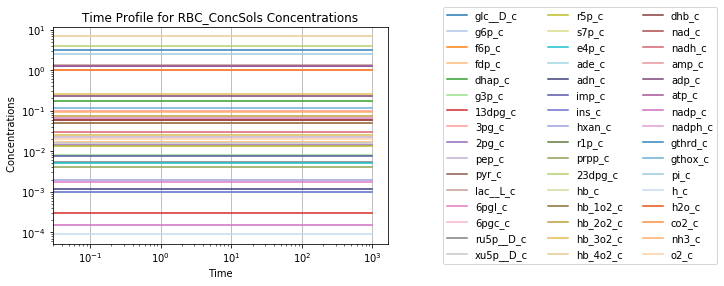

In [12]:
t0, tf = (0, 1e3)
sim_core = Simulation(core_hb)
sim_core.find_steady_state(
    core_hb, strategy="simulate",
    update_values=True)
conc_sol_ss, flux_sol_ss = sim_core.simulate(
    core_hb, time=(t0, tf, tf*10 + 1))
# Quickly render and display time profiles
conc_sol_ss.view_time_profile()

The above graph shows that the core RBC model is now at steady state.

<font color=red>**(iii)**</font>

In [13]:
sim = Simulation(core_hb)
conc_sol, flux_sol = sim.simulate(core_hb, time=(t0, tf), perturbations={"kf_ATPM": "kf_ATPM * 1.2"})

Hb_total = " + ".join([met.id for met in hemoglobin.metabolites if "hb" in met.id])
OHb = " + ".join(["*".join([met.id[3], met.id]) for met in hemoglobin.metabolites 
                  if "hb" in met.id and "o2_c" in met.id])



In [14]:
solutions = {}
for k in [47,57,67]:
    conc_sol, flux_sol = sim.simulate(core_hb, time=(t0, tf), perturbations={"o2_b": "o2_b/70 * {0}".format(k)})
    solutions["{0}".format(k)] = [conc_sol,flux_sol]

metabolites1 = [met.id for met in hemoglobin.metabolites if "hb" in met.id]
metabolites2 = ["*".join([met.id[3], met.id]) for met in hemoglobin.metabolites 
                  if "hb" in met.id and "o2_c" in met.id]
Hb_total = " + ".join([met.id for met in hemoglobin.metabolites if "hb" in met.id])
OHb = " + ".join(["*".join([met.id[3], met.id]) for met in hemoglobin.metabolites 
                  if "hb" in met.id and "o2_c" in met.id])
r_forms = Hb_total.replace(" + dhb_c", "")
ratios = {"$r_{OHb}$": ["({0})/(4*({1}))".format(OHb, Hb_total),metabolites1],
          "$r_{T/R}$": ["(dhb_c)/({0})".format(r_forms),metabolites1],
         "$r_{23DPG}$": [
        "dhb_c/(_23dpg_c + dhb_c)",
        ["dhb_c", "_23dpg_c"]]}
ratios

{'$r_{OHb}$': ['(1*hb_1o2_c + 2*hb_2o2_c + 3*hb_3o2_c + 4*hb_4o2_c)/(4*(hb_c + hb_1o2_c + hb_2o2_c + hb_3o2_c + hb_4o2_c + dhb_c))',
  ['hb_c', 'hb_1o2_c', 'hb_2o2_c', 'hb_3o2_c', 'hb_4o2_c', 'dhb_c']],
 '$r_{T/R}$': ['(dhb_c)/(hb_c + hb_1o2_c + hb_2o2_c + hb_3o2_c + hb_4o2_c)',
  ['hb_c', 'hb_1o2_c', 'hb_2o2_c', 'hb_3o2_c', 'hb_4o2_c', 'dhb_c']],
 '$r_{23DPG}$': ['dhb_c/(_23dpg_c + dhb_c)', ['dhb_c', '_23dpg_c']]}

In [15]:
metabolites1

['hb_c', 'hb_1o2_c', 'hb_2o2_c', 'hb_3o2_c', 'hb_4o2_c', 'dhb_c']

mass/visualization/visualization_util.py:806 UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


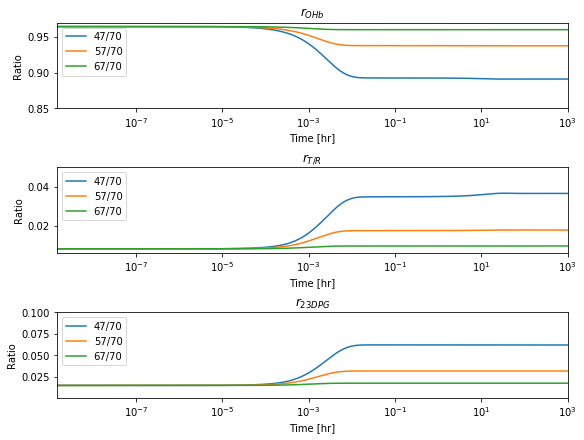

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 6), constrained_layout=True)
(ax1, ax2, ax3) = axes.flatten()

for number, (conc_sol,flux_sol) in solutions.items():
    for ratio_id, (equation, variables) in ratios.items():
        conc_sol.make_aggregate_solution(
            ratio_id, equation, variables)
    
    plot_time_profile(conc_sol, observable=list(ratios.keys())[0], ax=ax1, 
                legend=[number+"/70","best"], plot_function="semilogx", 
                xlabel="Time [hr]", ylabel="Ratio", 
                xlim=(t0, tf), ylim=(0.85, .97),
                title=(list(ratios.keys())[0]));
    plot_time_profile(conc_sol, observable=list(ratios.keys())[1], ax=ax2, 
                legend=[number+"/70","best"], plot_function="semilogx", 
                xlabel="Time [hr]", ylabel="Ratio", 
                xlim=(t0, tf),  ylim=(0.006, 0.05),
                title=(list(ratios.keys())[1]));
    plot_time_profile(conc_sol, observable=list(ratios.keys())[2], ax=ax3, 
                legend=[number+"/70","best"], plot_function="semilogx", 
                xlabel="Time [hr]", ylabel="Ratio", 
                xlim=(t0, tf),  ylim=(0.00001, 0.1),
                title=(list(ratios.keys())[2]));

__Interpretation:__ 
Looking at this graph, one can see that, as the oxygen concentration decreases among the three different levels, we see a corresponding decrease in oxygen carrying by hemoglobin in the red blood cell. Each level shows a non-linear decrease in the oxygen binding ratio, suggesting an allosteric response. This makes sense 23DPG is an allosteric inhibitor of hemoglobin, that stabilizes the taut form of hemoglobin, as exhbitied by the tandem increase in the 23DPG ratio and the T/R ratio. Furthermore, each new level exhibits a signmoidal change in bound oxygen, fraction of bound inhibitor, and the T/R ratio, further confirming the allosteric response to the change in oxygen levels. Finally, the increased fraction of bound 23DPG and higher T/R ratio, suggests that less oxygen can bind to hemoglobin, and thus the red blood cells can carry less oxygen to tissues throughout the body. A consequence of this is a decrease in the oxygen availiable for oxidative phosphorylation in other tissues. (Optional: Over time, the body will response to the decrease in bound oxygen, and will increase the number of red cells in circulation to effectively increase the hemoglobin in the blood, allowing for greater transfer from oxygen in the lungs to the blood.)

## Question 2: PFK module (34 Points)

> (i)  Add the PFK enzyme module to the core RBC model from problem 1. Simulate to steady state and update the conditions of your model. Graphically show your model in its steady state. 

> (ii) Compare how energy charge changes when there is a 20% increase of ATP usage in the core RBC model with PFK to the a model with glycolysis and PFK only. Explain the observed differences. 

> (iii) Compare how concentrations of FDP and F6P change when there is a sudden pulse of glucose at (t=0) doubling its initial concentration. Perform this simulation in the core RBC model with PFK, and in a model with glycolysis and PFK only. Explain the observed differences between the plots. 

__Notes:__ 
    
* When adding an enzyme module, remember to delete the original reaction it represents (e.g. delete PYK from model to add PYK module)


__(i) Expected Output__:
* A plot of the steady state concentrations with a caption. 

__(ii) Expected Output__:
* One plot containing two solutions representing each model
* Interpretation of the results. 

__(iii) Expected Output__:
* Two plots containing two solutions representing each model.
* A phase portrait of f6p and fdp for each model.
* Interpretation of the results.    

### <font color=red> __Grading:__ </font>

**(i)**
- A plot of steady state concentrations of the combined model +2 (only award 1 point if there is no caption)

**(ii)**
- One plot containing two solutions representing each model +4
> - There should be a larger dip in the GLC+PFK model than the core_PFK model
> - + 1 for having each solution be on the same graph
> - + 2 for having a larger dip in the GLC_PFK model than the RBC_PFK model.
> - + 1 for having all graphs have xlimits, ylimits, and labels for each axis as well as a title.
- Interpretation of the results +4
> -  +2 Students should explain how each model's energy charge changes due to the perturbation in ATP usage. + 1 for each model they analyze
> - +2 Students should explain how the lesser dip in the RBC_PFK model is due to the larger network having reactions that dampen, diffuse, or modify the response to the perturbation. Award points if they mention the reason for the difference being something related to the core_RBC model having a larger reaction network.

**(iii)**
- A plot containing two solutions for the change in FDP over time +4
    > - +1 for having each solution be on the same graph
    > - +2 for having a correct graph
    > - +1 for correct formating of the graph (legends, axis labels, title, etc) 
- A plot containing two solutions for the change in F6P over time +4
    > - +1 for having each solution be on the same graph
    > - +2 for having a correct graph
    > - +1 for correct formating of the graph (legends, axis labels, title, etc) 
- A Phase Portrait between f6p and fdp with both model solutions. +4
    > - +1 for having each solution be on the same graph
    > - +2 for having a correct graph ( or one in the ballpark of correct)
    > - +1 for correct formating of the graph (legends, axis labels, title, etc) 
- Interpretation of the above with an explaination of possible reasons for the differences between the first two graphs, pointing to known information about the two models as evidence. +10
    > - +2 for mentioning how the concentration of FDP changes for each model
    > - +3 for mentioning how the concentration of F6P changes for each model
    > - +3 for mentioning how the two concentrations change with regards to each other over time for each model
    > - +4 an explaination of the causes of these differences are likely due to the difference in model scope (presence of PPP fluxes, other pathways, etc.) Alternatively, mentioning the reason for the differences between the two models for each of the above plots when each plot is described and compared is fine as well



<font color=red>**(i)**</font>

/anaconda2/envs/MasspyEnv/lib/python3.7/site-packages/cobra/core/model.py:716 UserWarning: need to pass in a list


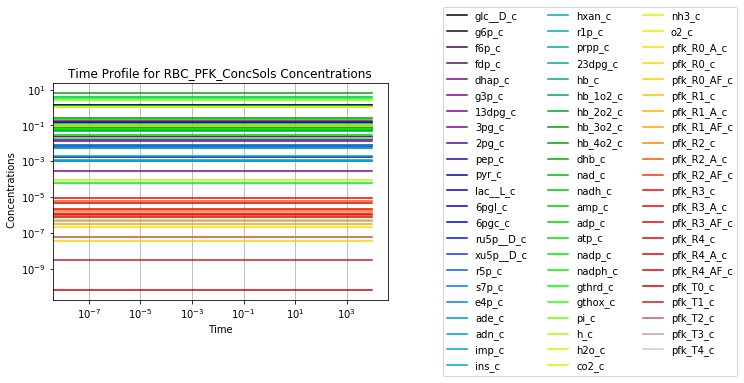

In [17]:
# Add PFK module to system
PFK = create_test_model("SB2_PFK")
core_PFK = core_hb.merge(PFK, inplace=False)
# Delete old PFK reaction
core_PFK.remove_reactions(core_PFK.reactions.PFK)

sim_PFK = Simulation(core_PFK)
t0, tf = (0, 1e4)
sim_PFK.find_steady_state(
    core_PFK, strategy="simulate", update_values=True,
    tfinal=1e5, steps=1e5)
conc_sol_ss, flux_sol_ss = sim_PFK.simulate(
    core_PFK, time=(t0, tf, tf*10 + 1))
conc_sol_ss.view_time_profile()

The above graph shows that the RBC_PFK model is now simulated to steady state.

<font color=red>**(ii)**</font>

In [18]:
# PFK with glycolysis
# Load glycolysis model
glycolysis = create_test_model("SB2_Glycolysis")

# Remove phosphate constraint in glycolysis as in Section 10.9
glycolysis.add_boundary(
    metabolite=glycolysis.metabolites.get_by_id("pi_c"),
    boundary_type="sink",  boundary_condition=2.5)
# Set forward rate constant, adjust units for time
glycolysis.reactions.SK_pi_c.kf = 0.23
glycolysis.reactions.SK_pi_c.Keq = 1

# Load PFK module
PFK = create_test_model("SB2_PFK")

# Add PFK module to system
glycolysis_PFK = glycolysis.merge(PFK, inplace=False)
# Delete old PFK reaction
glycolysis_PFK.remove_reactions([glycolysis_PFK.reactions.PFK])

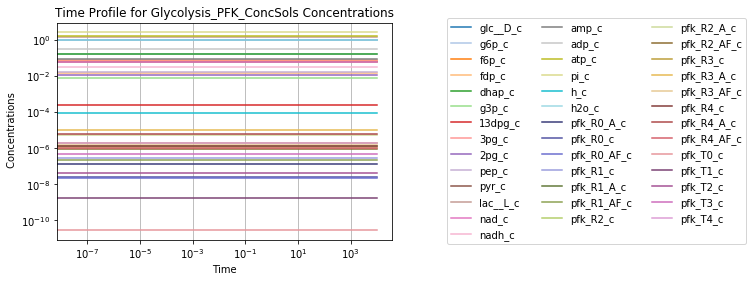

In [19]:
sim_PFKgly = Simulation(glycolysis_PFK)

t0, tf = (0, 1e4)
sim_PFKgly.find_steady_state(
    glycolysis_PFK, strategy="simulate", update_values=True,
    tfinal=1e5, steps=1e5)

conc_sol_gly_ss, flux_sol_gly_ss = sim_PFKgly.simulate(
    glycolysis_PFK, time=(t0, tf, tf*10 + 1))
conc_sol_gly_ss.view_time_profile()

The above time profile shows that the glycolysis-PFK model is now at steady state.

In [20]:
# Load glycolysis and PFK models
glycolysis = create_test_model("SB2_Glycolysis")
PFK = create_test_model("SB2_PFK")
sim_PFKgly = Simulation(glycolysis_PFK)
sim_PFKgly.find_steady_state(
    glycolysis_PFK, strategy="simulate", update_values=True,
    tfinal=1e5, steps=1e5)

# Add PFK module to system and delete old PFK reaction
glycolysis_PFK = glycolysis.merge(PFK, inplace=False)
glycolysis_PFK.remove_reactions(glycolysis_PFK.reactions.PFK)

/anaconda2/envs/MasspyEnv/lib/python3.7/site-packages/cobra/core/model.py:716 UserWarning: need to pass in a list


In [21]:
#Simulate both models
t0, tf = (0, 1e4)
conc_sol, flux_sol = sim_PFK.simulate(
    core_PFK, time=(t0, tf, tf*10 + 1),
    perturbations={"kf_ATPM": "kf_ATPM * 1.20"});
conc_solg,flux_solg = sim_PFKgly.simulate(glycolysis_PFK, time=(t0, tf, tf*10 + 1),
    perturbations={"kf_ATPM": "kf_ATPM * 1.20"});


conc_sol.make_aggregate_solution(
        "energy_charge", "(2*atp_c + adp_c)/(2*(atp_c + adp_c + amp_c))", ["atp_c","adp_c","amp_c"]);
conc_solg.make_aggregate_solution("energy_charge", "(2*atp_c + adp_c)/(2*(atp_c + adp_c + amp_c))", ["atp_c","adp_c","amp_c"]);

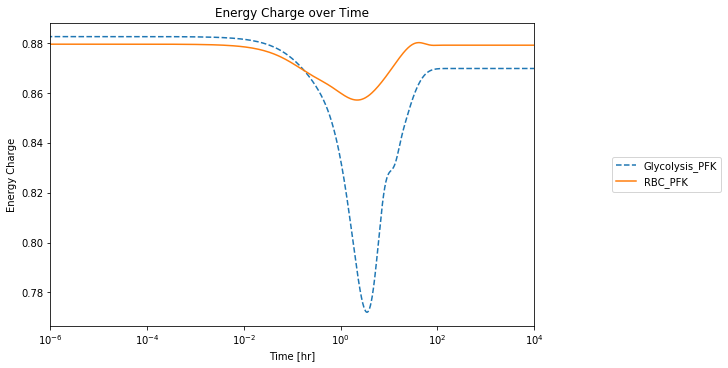

In [22]:
linestyles = ["--", "-"]
colors = ["grey", "black"]

fig2i, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5),
                            constrained_layout=True)


linestyles = ["--", "-"]
colors = ["grey", "black"]

for i, (model, sim) in enumerate(zip([glycolysis_PFK, core_PFK],
                                     [sim_PFKgly, sim_PFK])):
    conc_solution = sim.concentration_solutions.get_by_id(
        "_".join((model.id, "ConcSols")))
    plot_time_profile(conc_solution, ax=ax,observable=["energy_charge"], legend=[model.id, "right outside"],
    plot_function="semilogx", xlim=(1e-6, tf),linestyle=linestyles[i],
    xlabel="Time [hr]", ylabel="Energy Charge",
    title=("Energy Charge over Time"));

__Interpretation__: While both the glycolysis+PFK and the RBC_PFK models have a dip in their energy charge, followed by an overshoot and return to steady state. Likely due to the presence of other pathways availiable to both produce and utilize ATP, the combined RBC +PFK model has a higher minimum value and a returns to a similar steady state than it had preperturbation, whereas the glycolysis+PFK model, lacking the additional pathways and regulation found in the RBC_PFK model, had a much lower local minima for its energy charge in the simulation, and returned to a slightly lower steady state than when it had started.

<font color=red>**(iii)**</font>

In [23]:
conc_sol, flux_sol = sim_PFK.simulate(
    core_PFK, time=(t0, tf, tf*10 + 1),
    perturbations={"glc__D_c": "glc__D_c * 2"});
conc_solg,flux_solg = sim_PFKgly.simulate(glycolysis_PFK, time=(t0, tf, tf*10 + 1),
    perturbations={"glc__D_c": "glc__D_c * 2"});

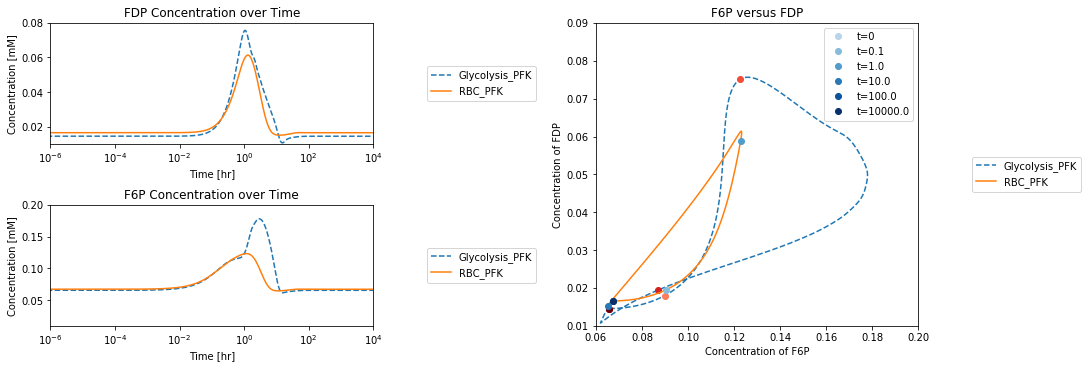

In [24]:
mentioninglinestyles = ["--", "-"]
colors = ["grey", "black"]

fig = plt.figure(figsize=(15, 5),constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[1, 1])


ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])

linestyles = ["--", "-"]
colors = ["grey", "black"]
time_points = [t0, 1e-1, 1e0, 1e1, 1e2, tf]
time_colors = [
    [mpl.colors.to_hex(c)
    for c in mpl.cm.Reds(np.linspace(0.3, 1, len(time_points)))],[
    mpl.colors.to_hex(c)
    for c in mpl.cm.Blues(np.linspace(0.3, 1, len(time_points)))]]
legends = ["upper left","upper right"]

for i, (model, sim) in enumerate(zip([glycolysis_PFK, core_PFK],
                                     [sim_PFKgly, sim_PFK])):
    conc_solution = sim.concentration_solutions.get_by_id(
        "_".join((model.id, "ConcSols")))
    plot_time_profile(conc_solution, ax=ax1,observable=["fdp_c"], legend=[model.id, "right outside"],
    plot_function="semilogx", xlim=(1e-6, tf),ylim=(0.01,0.08),linestyle=linestyles[i],
    xlabel="Time [hr]", ylabel="Concentration [mM]",
    title=("FDP Concentration over Time"));
    plot_time_profile(conc_solution, ax=ax2,observable=["f6p_c"], legend=[model.id, "right outside"],
    plot_function="semilogx", xlim=(1e-6, tf),ylim=(0.01,0.2),linestyle=linestyles[i],
    xlabel="Time [hr]", ylabel="Concentration [mM]",
    title=("F6P Concentration over Time"));
    
    plot_phase_portrait(conc_solution, ax=ax3,x="f6p_c",y="fdp_c",xlim =(0.06,0.2), ylim= (0.01,0.09), legend=[model.id, "right outside"],
    linestyle=linestyles[i],
    xlabel="Concentration of F6P", ylabel="Concentration of FDP",
    title=("F6P versus FDP"),annotate_time_points=time_points,
        annotate_time_points_color=time_colors[i],
        annotate_time_points_legend=legends[i]);

__Interpretation__: From the plot results, it can be seen that the glycolysis_PFK Model is more effected by the pulse of glucose than the RBC_PFK model. This is likely due to the pentose phosphate pathway redirecting glycolytic flux into the pentose phosphate pathway Looking at the fdp graph, we can observe that, because of the presence of the pentose phosphate pathway, the pulse of glucose into the system has less of an effect on the concentration of fdp, due to glycolytic flux being redirected into the pentose phosphate pathway. Furthermore, looking at the f6p node, we can see a similarly limited response to the glucose pulse, also due to the efflux of glucose-6-phosphate into the pentose phosphate pathway upstream of the f6p node. As a result, there is a more distributed increase and decrease in the concentration of f6p. Furthermore, looking at the phase portrait on the right(time points for core_RBC in blue, time points for glycolysis_PFK in red), we can see that the distance from steady state in the core_RBC model is less, and the return to the previous concentration is tighter, consistent with the greater amount of regulation present in the integrated pathway. In contrast, the glycolysis+PFK model shows a much larger deviation from steady state, with greater overshoots and thus a less tight response, consistent with the lack of dampening from other pathways. Overall we can see that the RBC_PFK_Model has a more dampened deviation from steady state due to its response to the glucose pulse, as, the presence of the other pathways acts to prevent it from being as perturbed from its steady state, and thus makes the system over all more stable.

## Question 3: Start to think about the G6PDH module! (36 Points)

G6PDH catalyzes an important step in pentose phosphate pathway and its deficiency can largely affect red blood cell metabolism. Do a literature search to identify **three different G6PDH modifications with at least one modification being a disease phenotype**. By disease phenotype, we mean the phenotypic change of G6PDH that results in a diseased state of the enzyme. 

> In one to two paragraphs per proposed modification, introduce the phenotypic change, the biological mechanism (genetic muation for example) responsible for such change and its physiological consequences. 

**Notes:** 
* Paragraphs do not and should not need to be long; ideally they should convey the information about the modification clearly and concisely. 
* Two paragraphs maximum per modification

### <font color=red> __Grading:__ </font>
 For Each Modification listed (out of 12):
 
 - +4 for mentioning the phenotypic change
 - +4 for mentioning the mechanism responsible
 - +4 for mentioning the physiological consequence
 
 
 The three modifications add up to a maximum of 36 points

Modification 1

<font color='red'>Answers may vary. Must have the phenotypic change, the mechanism responsible, and the physiological consequence </font> 

Modification 2

<font color='red'>Answers may vary. Must have the phenotypic change, the mechanism responsible, and the physiological consequence </font> 

Modification 3

<font color='red'>Answers may vary. Must have the phenotypic change, the mechanism responsible, and the physiological consequence </font> 